# intro

In [1]:
import keras
import numpy  as np
import pandas as pd
import pylab  as pl

import edge ## my module

Using TensorFlow backend.


# data

In [2]:
## data = edge.Generator().generate_data(10000, bias=0) ## data generation takes about 30 seconds
## data.to_csv("data.csv", index=False)

dim = 7
data = pd.read_csv("data_bias-0.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 114 entries, x_00 to y_noise
dtypes: float64(114)
memory usage: 8.7 MB


In [3]:
data.head()

x_00     x_01     x_02     x_03     x_04     x_05     x_06     x_10  \
0  0.96726  1.00000  0.36932  0.00000  0.00000  0.01683  0.00000  0.95903   
1  0.00000  0.12974  0.79997  1.00000  0.98085  0.98539  1.00000  0.01630   
2  0.98206  1.00000  0.99937  0.87809  0.40229  0.03168  0.01096  1.00000   
3  1.00000  0.96354  1.00000  1.00000  1.00000  1.00000  0.99918  0.94645   
4  1.00000  1.00000  0.95919  1.00000  0.98891  1.00000  0.99672  0.99187   

      x_11     x_12  ...  y_slope  y_intercept   y_root     y_Ax     y_Ay  \
0  0.45658  0.00000  ... -1.12788      0.45067  0.39957 -0.00000  0.45067   
1  0.04272  0.06244  ...  0.77902     -0.15905  0.20417  0.20417  0.00000   
2  0.71801  0.26956  ... -0.43403      0.33810  0.77898 -0.00000  0.33810   
3  0.97657  1.00000  ... -0.68854      1.23333  1.79122  0.33888  1.00000   
4  0.97198  0.98339  ... -0.59926      0.93479  1.55990 -0.00000  0.93479   

      y_Bx     y_By  y_length   y_area  y_noise  
0  0.39957  0.00000   0.60230  0.09004  2.97307  
1  1.00000  0.61997   1.00882  0.24670  1.86775  
2  0.77898  0.00000   0.84919  0.13169  2.89770  
3  1.00000  0.54479   0.80268  0.84953  2.76522  
4  1.00000  0.33553   1.16581  0.63516  2.17041  

[5 rows x 114 columns]

<Figure size 432x288 with 0 Axes>

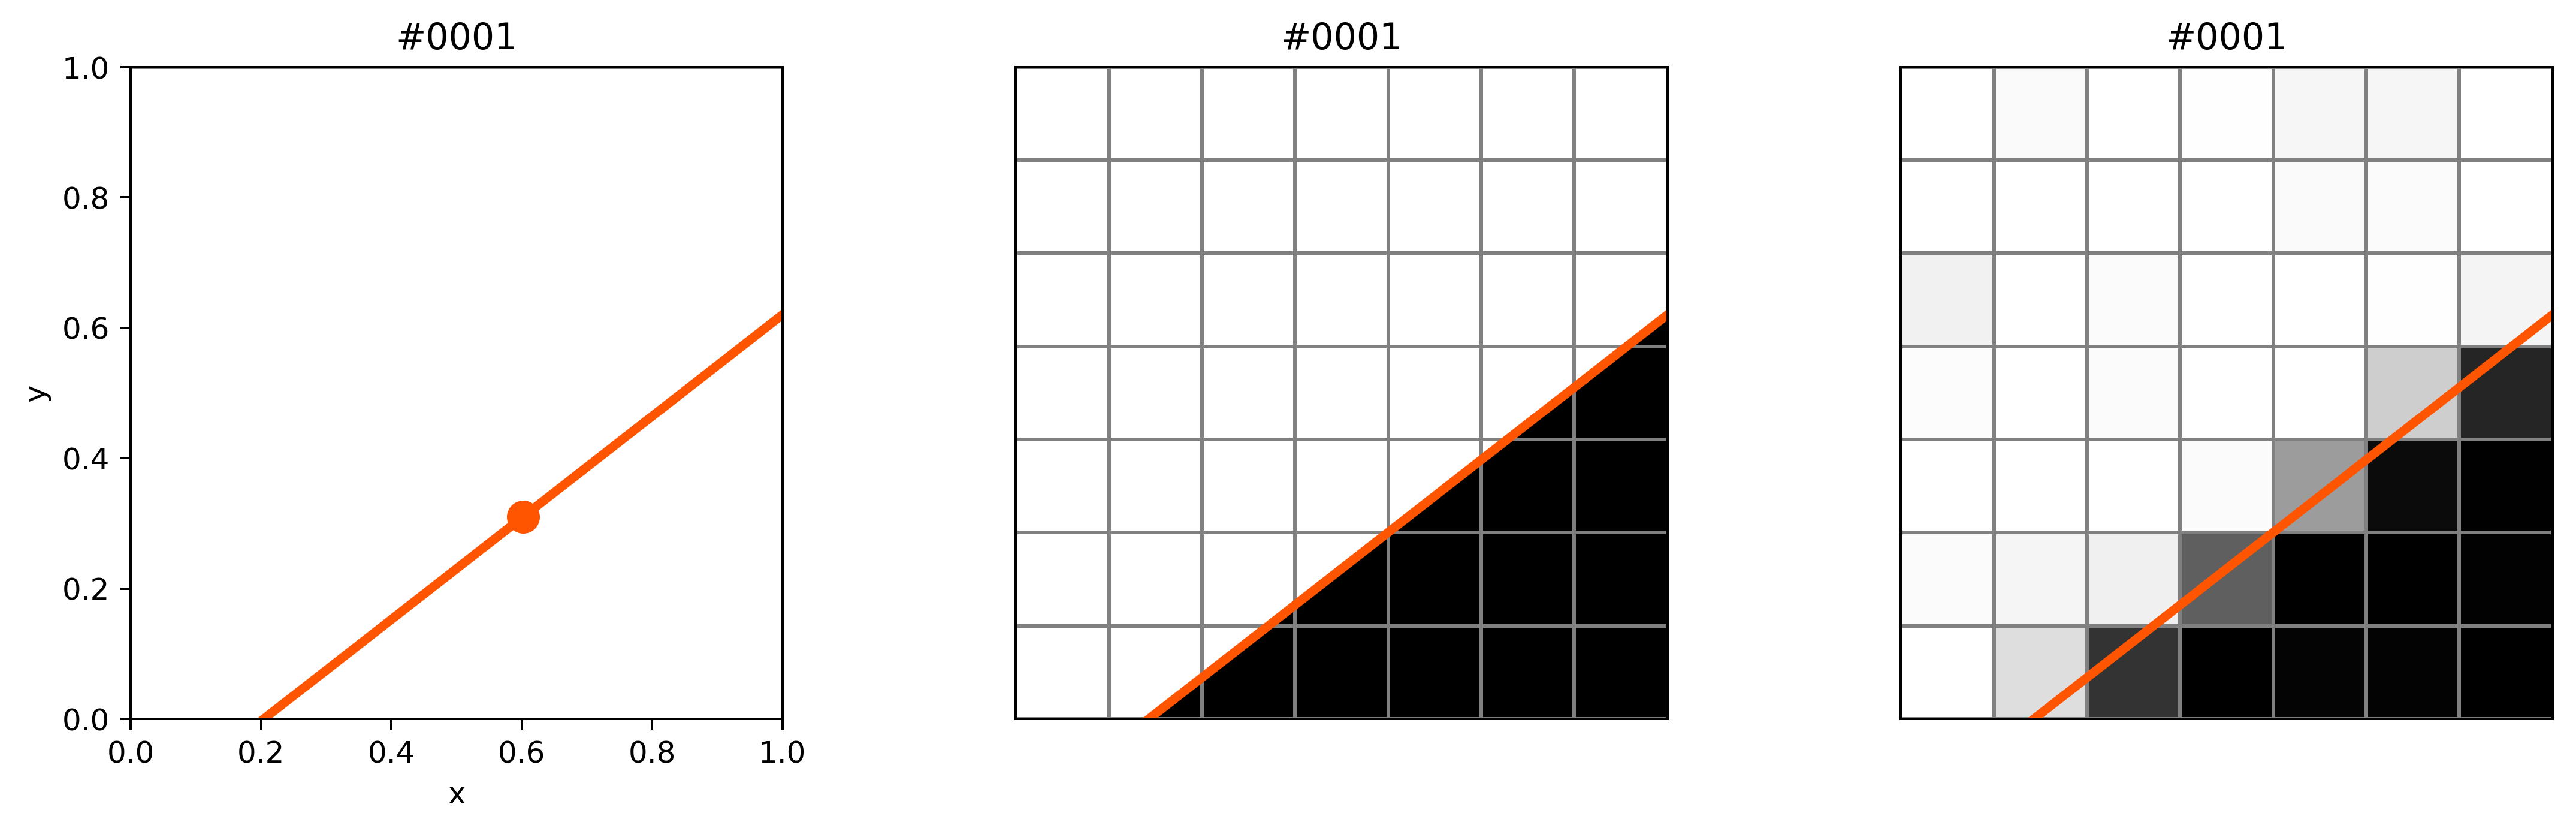

In [4]:
edge.fancy(data, flavour=["initial", "integral", "line"], index=1, bias=0, linewidth=3)

<Figure size 432x288 with 0 Axes>

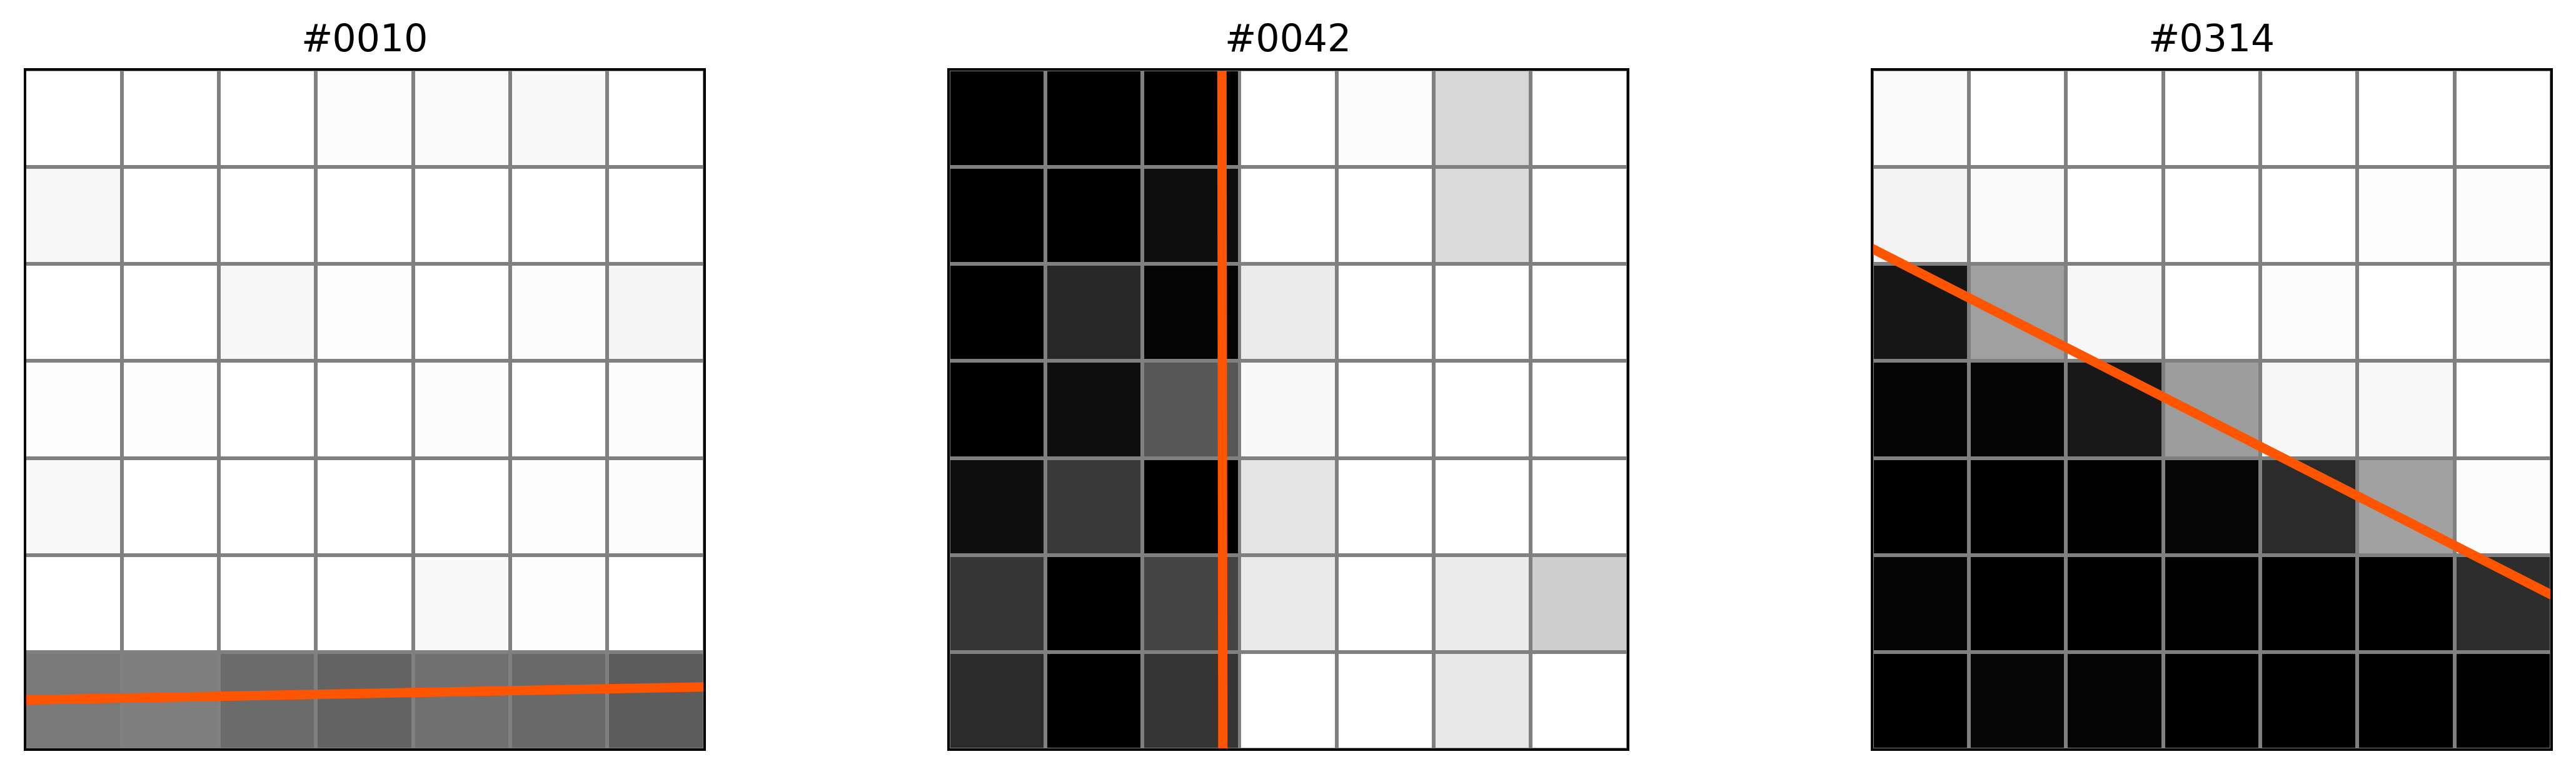

In [5]:
edge.fancy(data, flavour="line", index=[10, 42, 314], linewidth=3)

<Figure size 432x288 with 0 Axes>

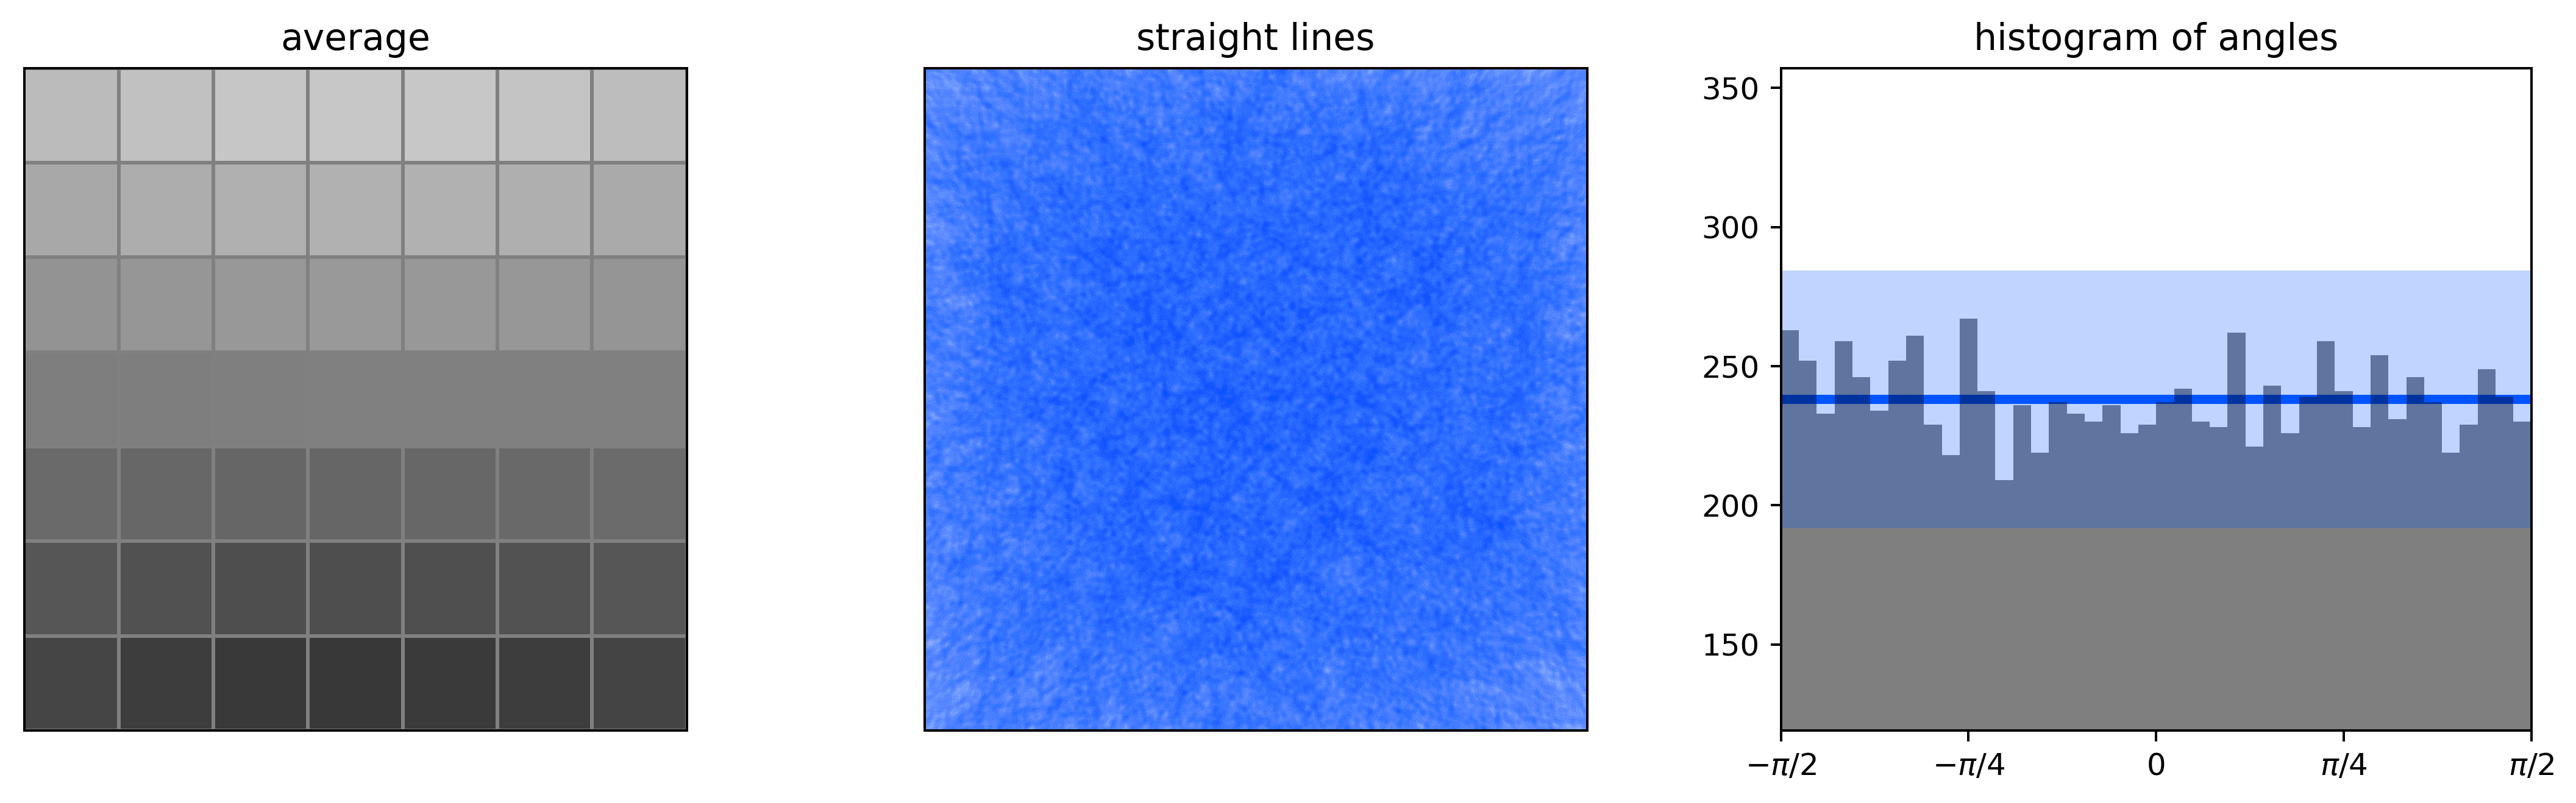

In [6]:
edge.fancy(data, flavour=["average", "lines", "angles"], index=None, bins=42, linewidth=3)
## "lines" plot takes about 2..3 minutes

<Figure size 432x288 with 0 Axes>

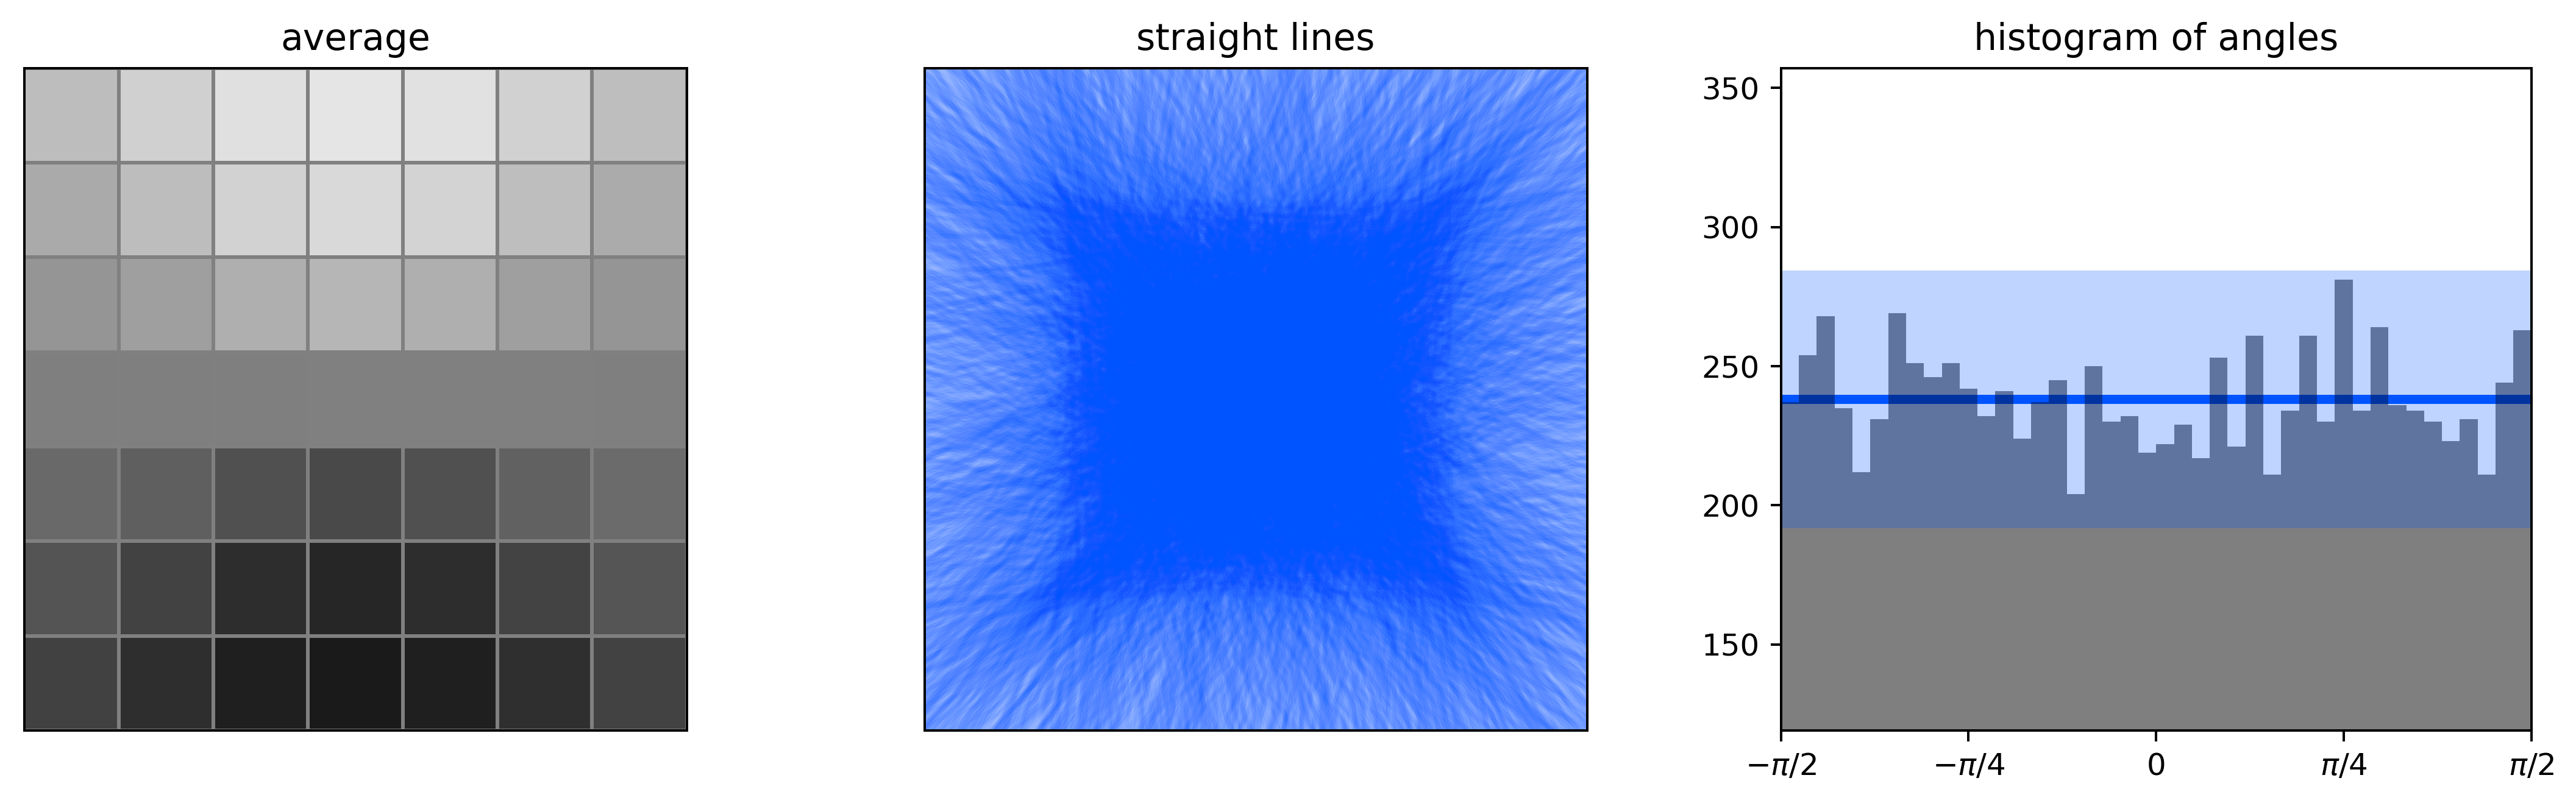

In [7]:
edge.fancy(pd.read_csv("data_bias-extra.csv"), flavour=["average", "lines", "angles"], index=None, bins=42, linewidth=3)
## "lines" plot takes 2..3 minutes

# area

$$
    \mathrm{area} \; A = \int_0^1 \mathrm{d}x \int_0^1 \mathrm{d}y \; f(x) \; \approx A_\mathrm{pix} \sum_{ij} X_{ij}
$$

<Figure size 432x288 with 0 Axes>

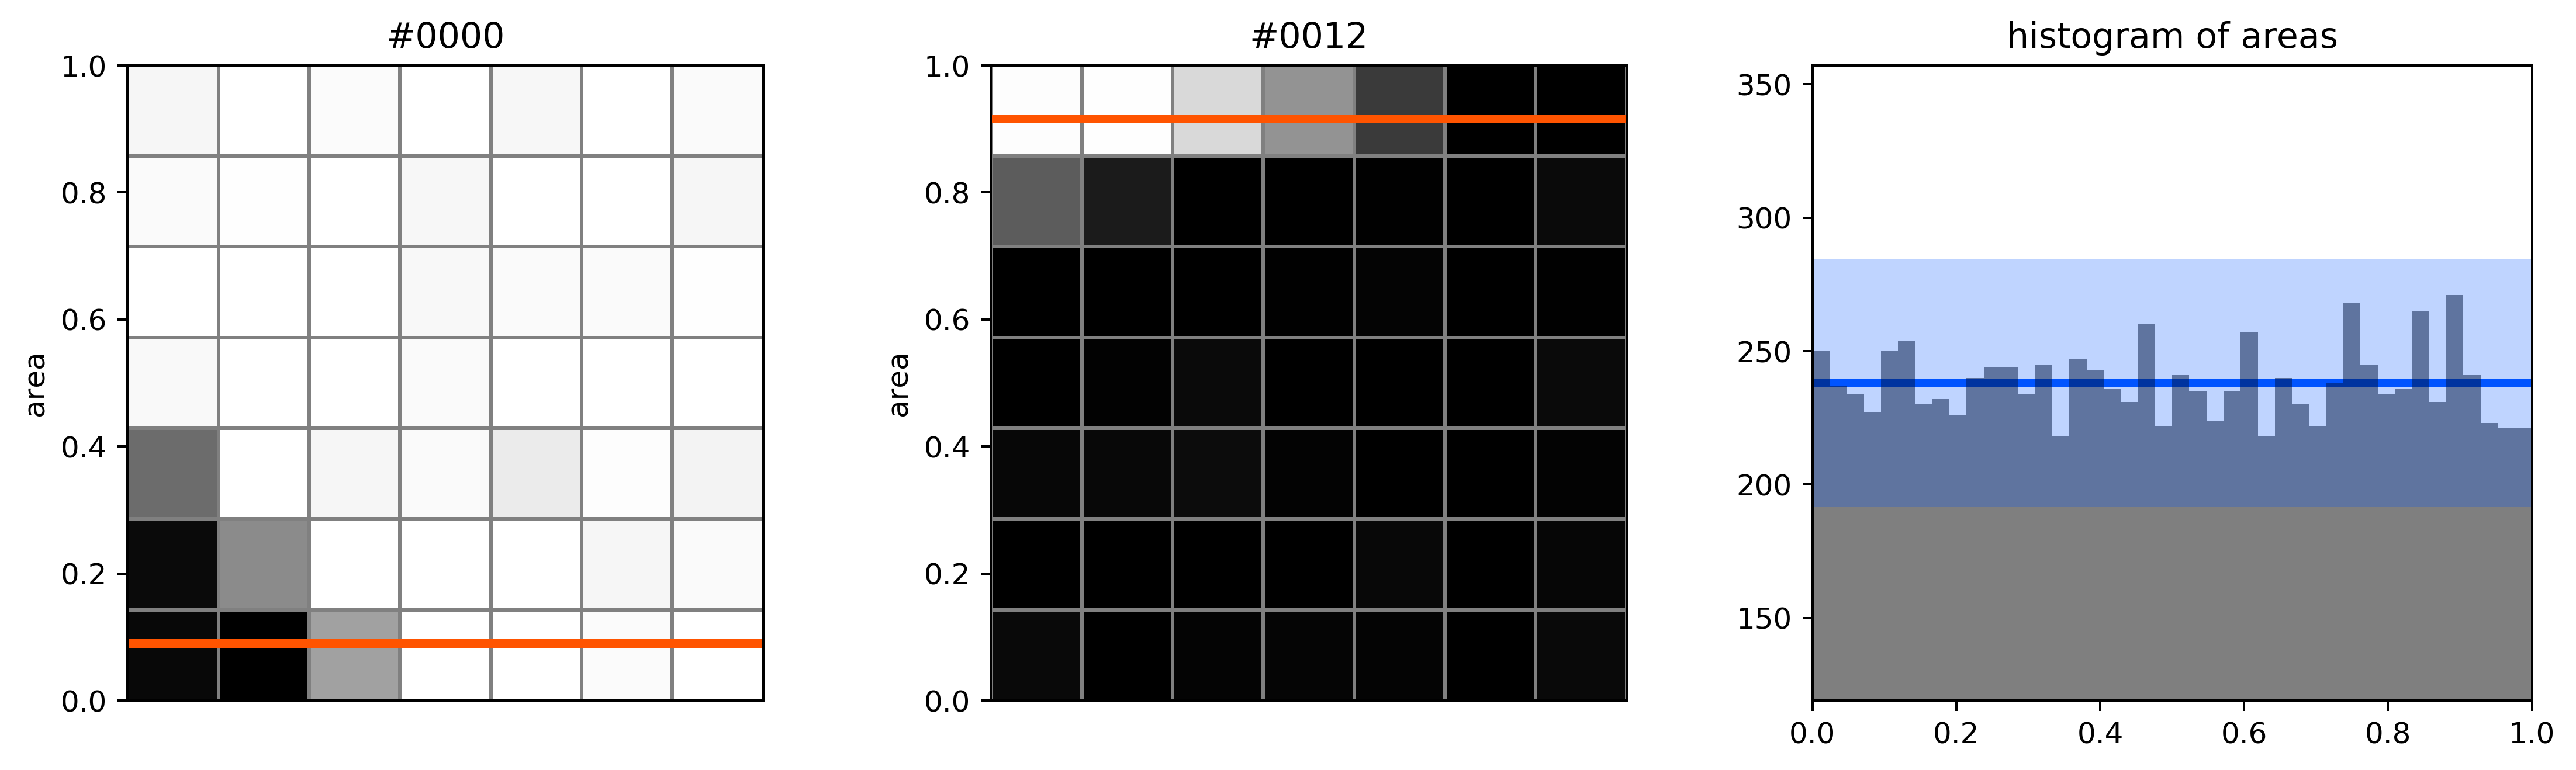

In [8]:
edge.fancy(data, flavour=["area", "area", "areas"], index=[0, 12], bins=42, linewidth=3)

In [9]:
from sklearn.model_selection import train_test_split


X = data.loc[:, "x_00" : f"x_{dim - 1}{dim - 1}"]
Y = data.loc[:, "y_area"]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=42, shuffle=False)

In [10]:
from keras.models       import Sequential
from keras.layers       import Dense
from keras.initializers import RandomUniform
from keras.optimizers   import Adam
from keras.callbacks    import Callback


model = Sequential()
model.add(Dense(1, input_dim=dim ** 2,
                use_bias=False, activation="relu",
                kernel_initializer=RandomUniform(minval=-0.1, maxval=0.1, seed=42)))

model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), ## defaults
              loss="mean_squared_error")


class WeightCallback(Callback):
    
    def on_train_begin(self, logs=None):
        self.weights = []

    def on_epoch_end(self, epoch, logs=None):
        self.weights.append(self.model.layers[0].get_weights()[0][:, 0])

In [11]:
callback = WeightCallback()
history  = model.fit(X_train, Y_train, epochs=300, batch_size=100, verbose=False, callbacks=[callback])
## training takes about 30 seconds

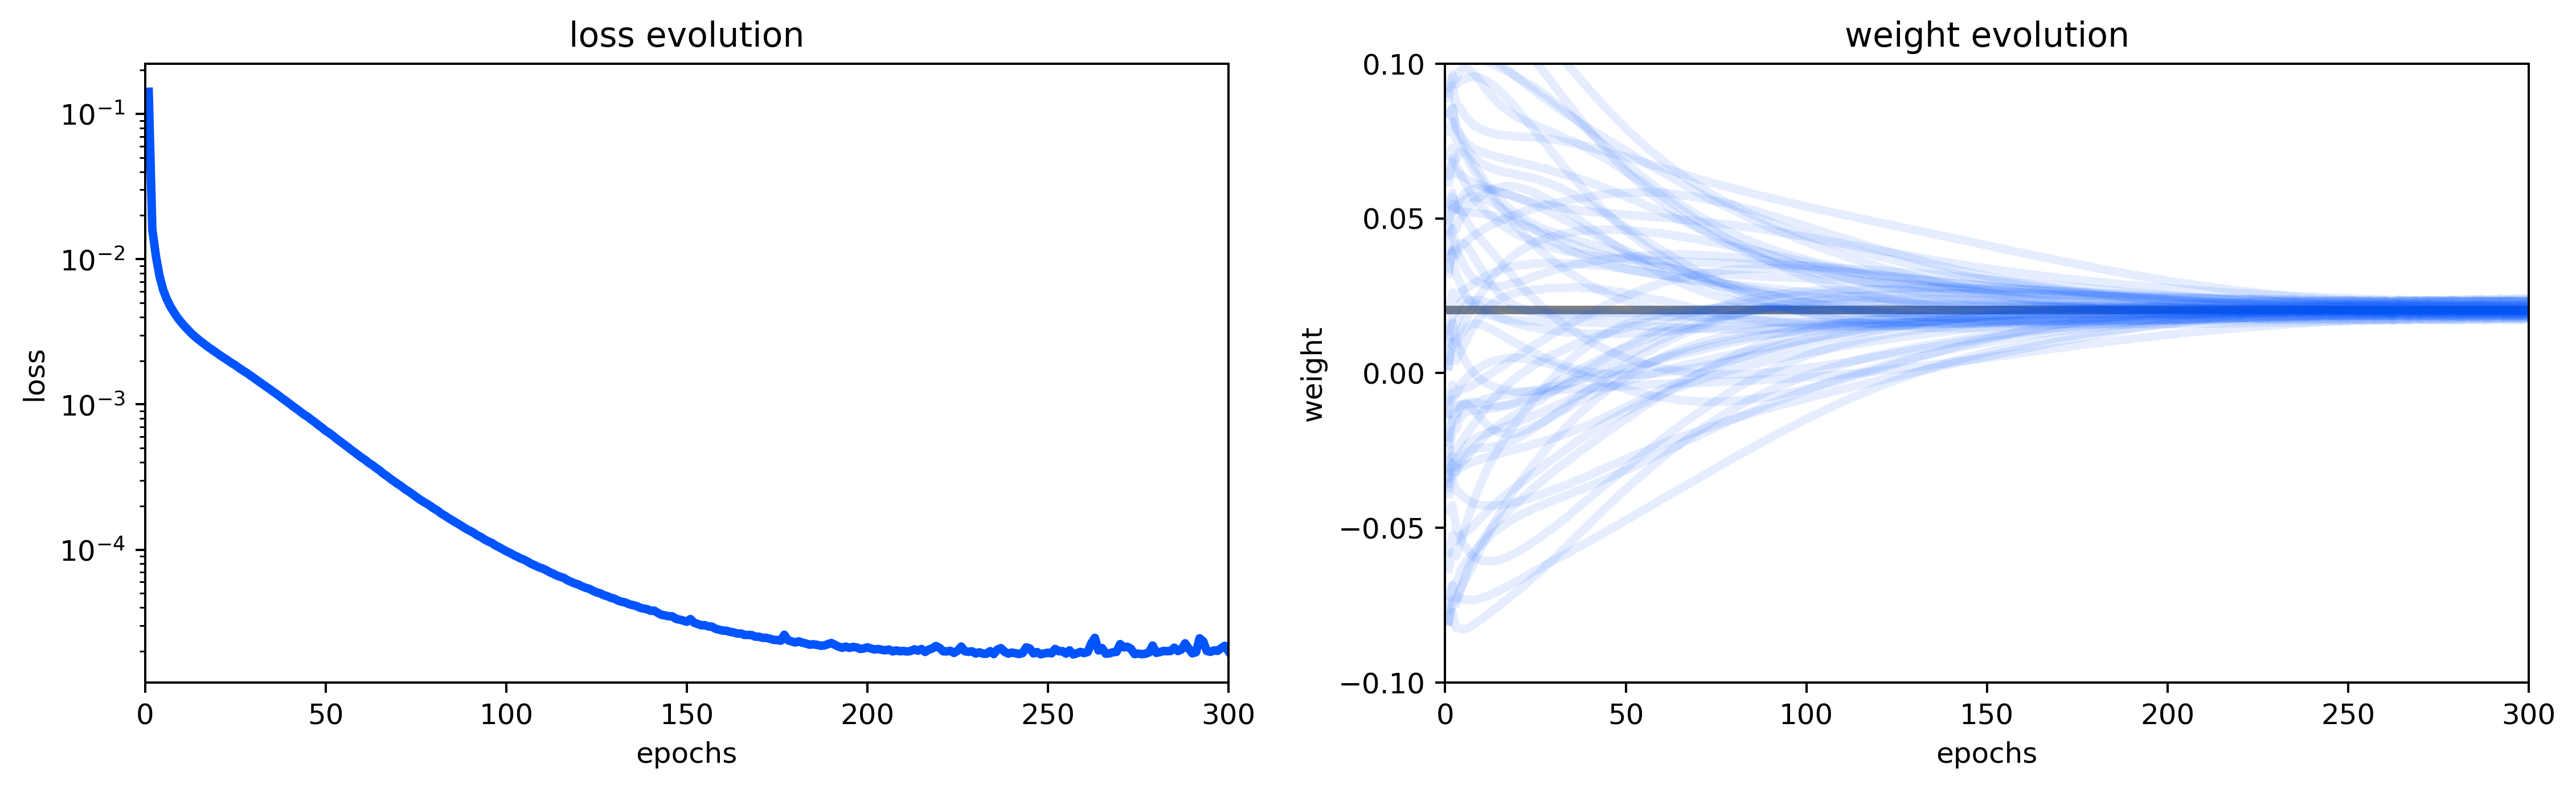

In [12]:
import edge
import numpy as np
import pylab as pl

losses  = np.array(history.history["loss"])
weights = np.array(callback.weights).T
edge.gaze(["loss", "weights"], losses=losses, weights=weights, linewidth=3)

In [13]:
loss = model.evaluate(X_test, Y_test, batch_size=128, verbose=False)
y = model.predict(X_test)[:, 0]
error = np.linalg.norm(Y_test - y) / np.linalg.norm(Y_test)
print(f" error: {(error * 100):2.3f} %")
print(f"(noise: {(np.mean(data.loc[:, 'y_noise'])):2.3f} %)")

 error: 0.736 %
(noise: 2.286 %)


<Figure size 432x288 with 0 Axes>

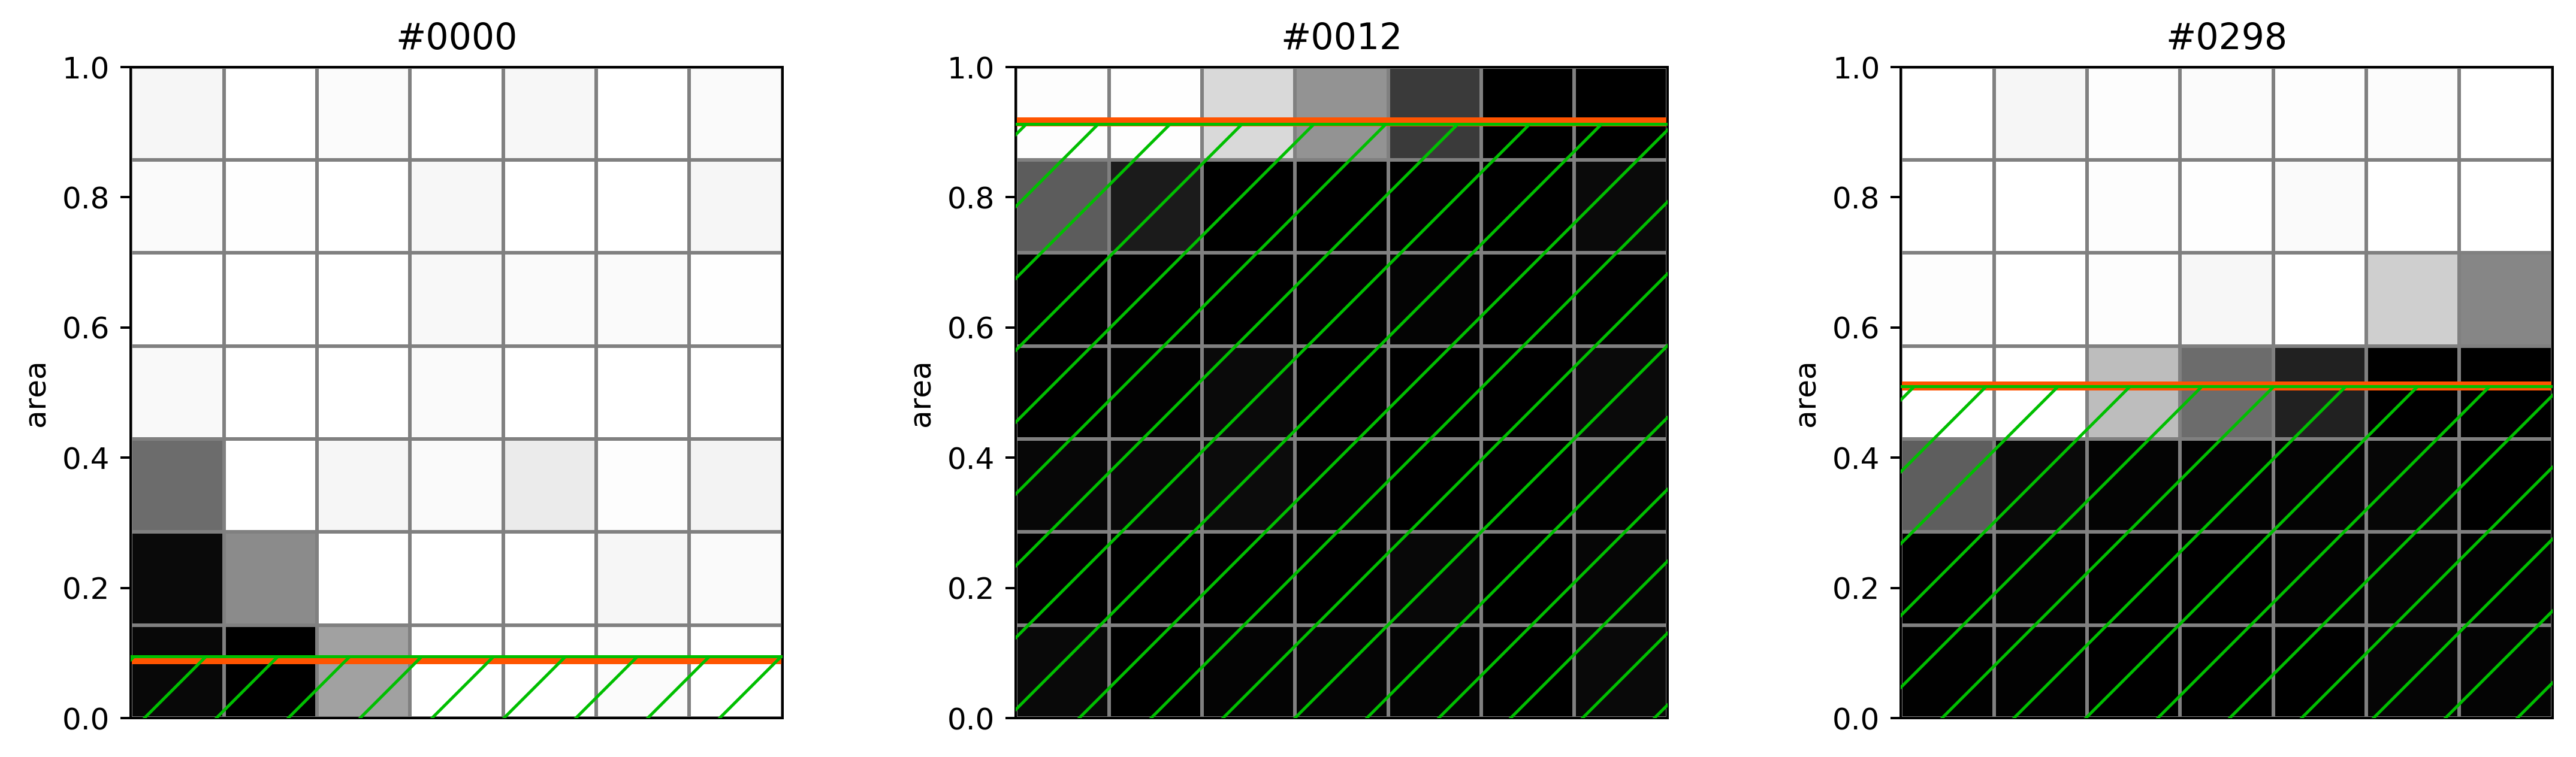

In [14]:
y = model.predict(X)[:, 0]
edge.fancy(data, flavour="area", index=[0, 12, 298], y=y, linewidth=3)

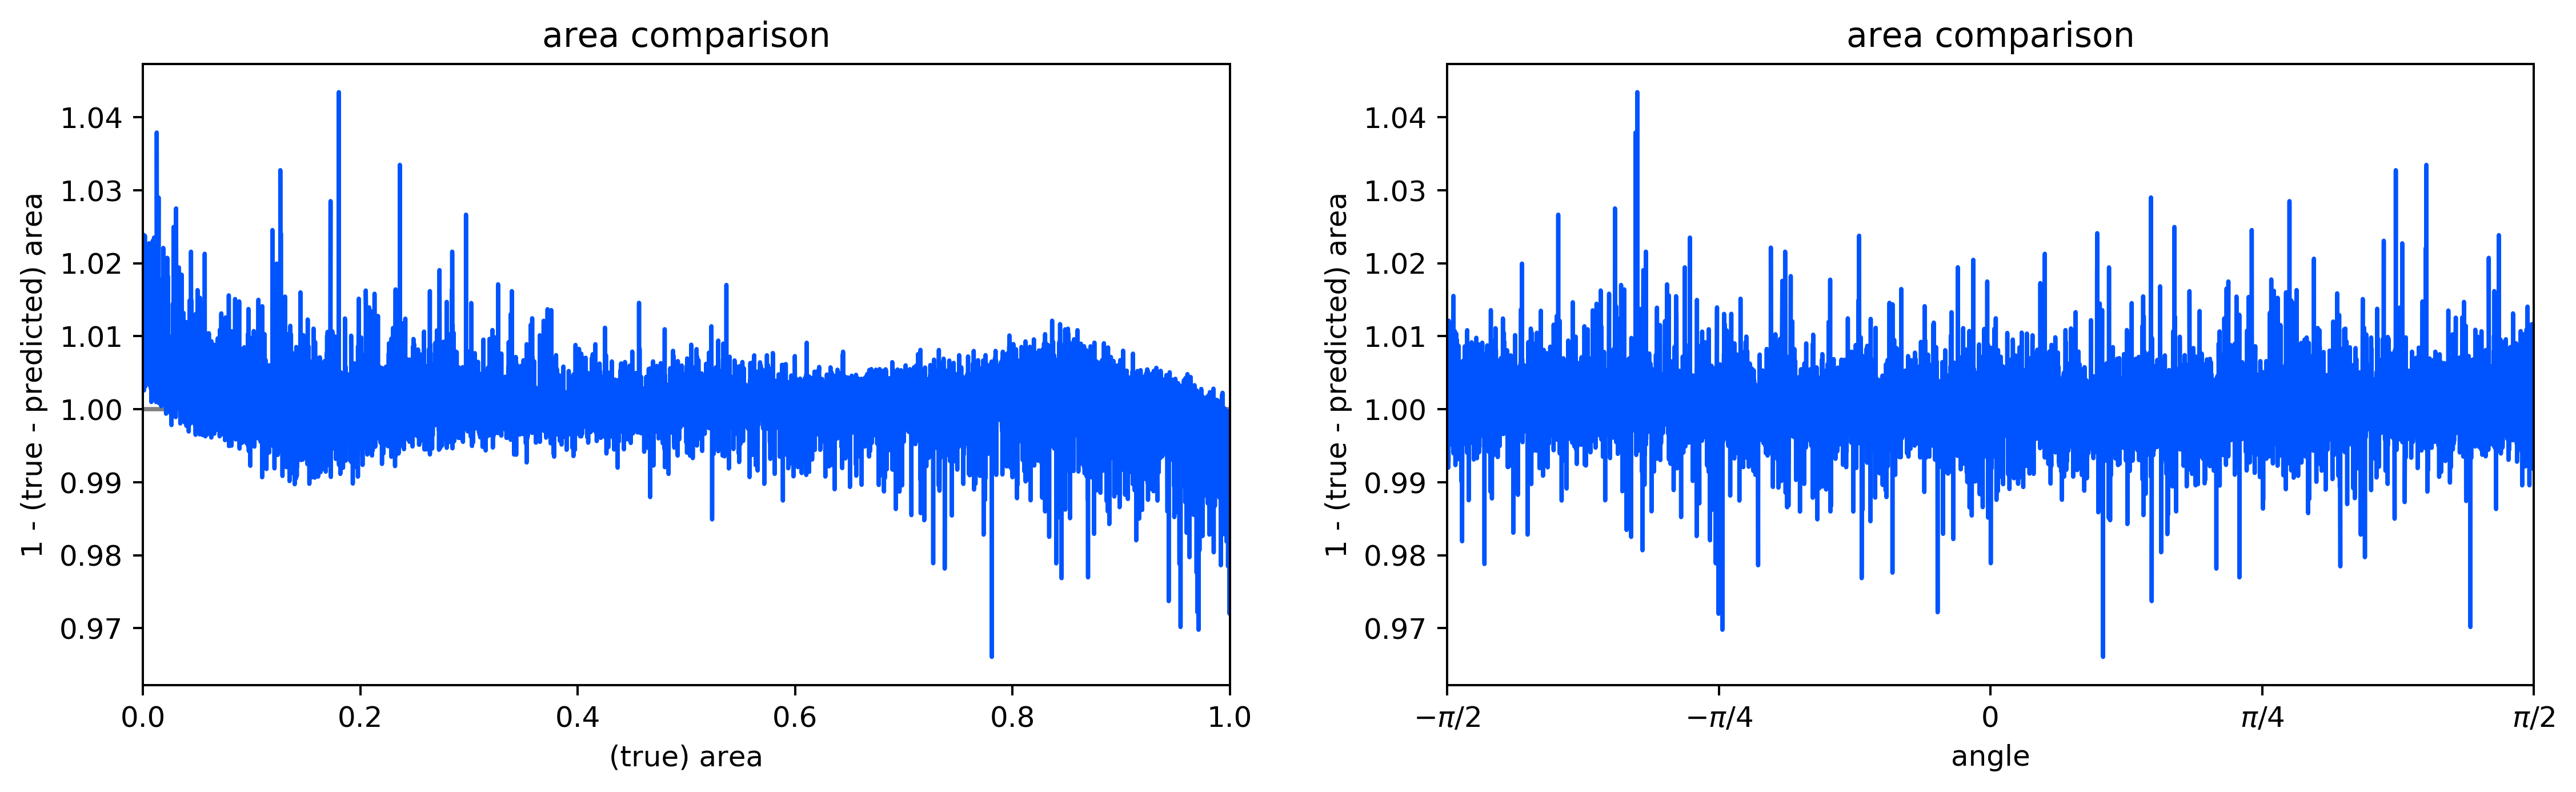

In [15]:
edge.gaze(["compare", "depend"], compare=(Y, y, "area"), angles=data.loc[:, "y_angle"])

In [16]:
from sklearn.model_selection import train_test_split


X = data.loc[:, "x_00" : f"x_{dim - 1}{dim - 1}"].values.reshape((-1, dim, dim, 1))
Y = data.loc[:, "y_area"].values.flatten()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8, random_state=42, shuffle=False)

In [17]:
from keras.models       import Sequential
from keras.layers       import Conv2D, Flatten, Dense
from keras.initializers import RandomUniform
from keras              import backend as K
from keras.regularizers import l2 as L2
from keras.optimizers   import Adam


kernel_shape = (3, 3)
kernel_mean  = 1 / np.prod(kernel_shape)
kernel_prior = lambda kernel : K.sum(kappa * K.square(kernel - kernel_mean))

kappa = 0.01 ## default

model = Sequential()
model.add(Conv2D(1, kernel_shape, strides=(1, 1), padding="same",
                 use_bias=False, activation="relu",
                 kernel_initializer=RandomUniform(minval= 0.0, maxval=0.2, seed=42),
                 kernel_regularizer=kernel_prior))
model.add(Flatten())
model.add( Dense(1,
                 use_bias=False, activation="relu",
                 kernel_initializer=RandomUniform(minval=-0.1, maxval=0.1, seed=42),
                 kernel_regularizer=L2(kappa)))

model.compile(optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False), ## defaults
              loss="mean_squared_error")

In [18]:
history = model.fit(X_train, Y_train, epochs=200, batch_size=100, verbose=False, callbacks=[callback])
## training takes about 20 seconds

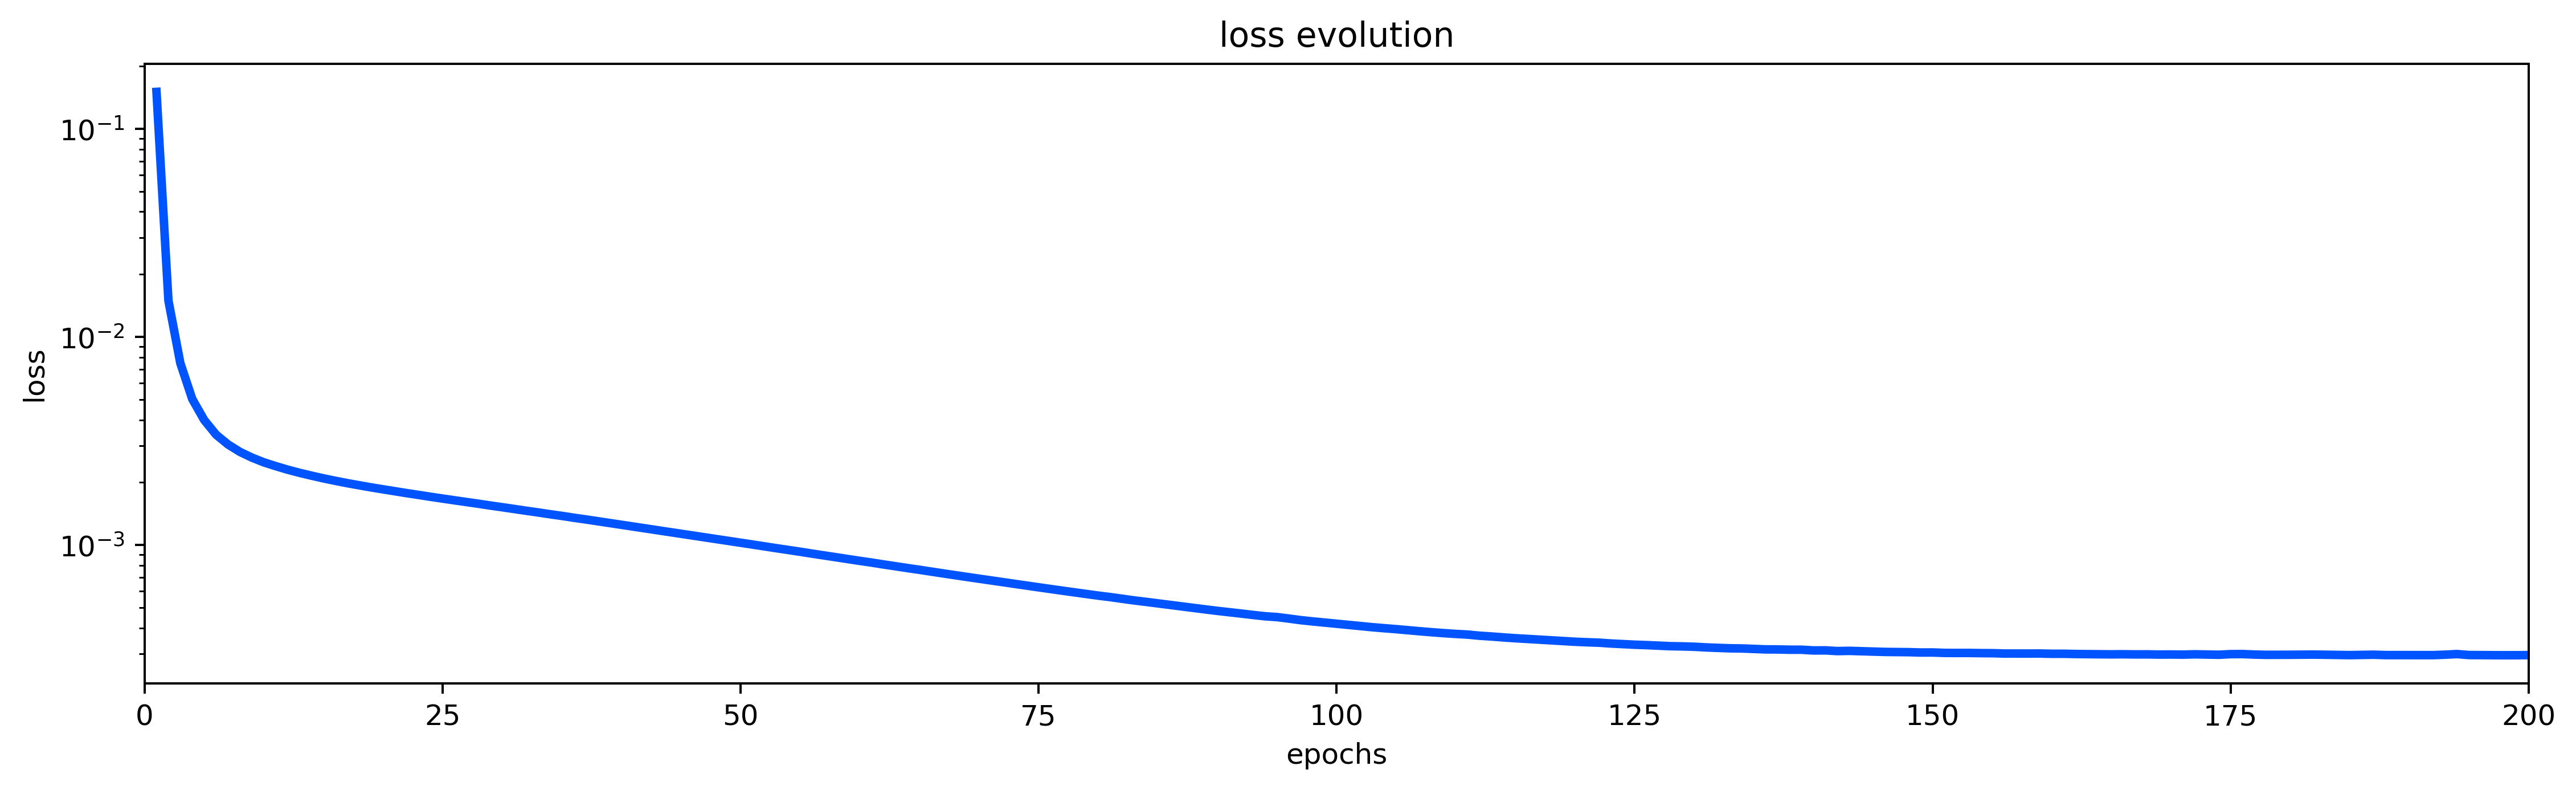

In [19]:
losses  = np.array(history.history["loss"])
edge.gaze("loss", losses=losses, linewidth=3)

In [20]:
loss = model.evaluate(X_test, Y_test, batch_size=128, verbose=False)
y = model.predict(X_test)[:, 0]
error = np.linalg.norm(Y_test - y) / np.linalg.norm(Y_test)
print(f" error: {(error * 100):2.3f} %")
print(f"(noise: {(np.mean(data.loc[:, 'y_noise'])):2.3f} %)")

 error: 0.985 %
(noise: 2.286 %)


<Figure size 432x288 with 0 Axes>

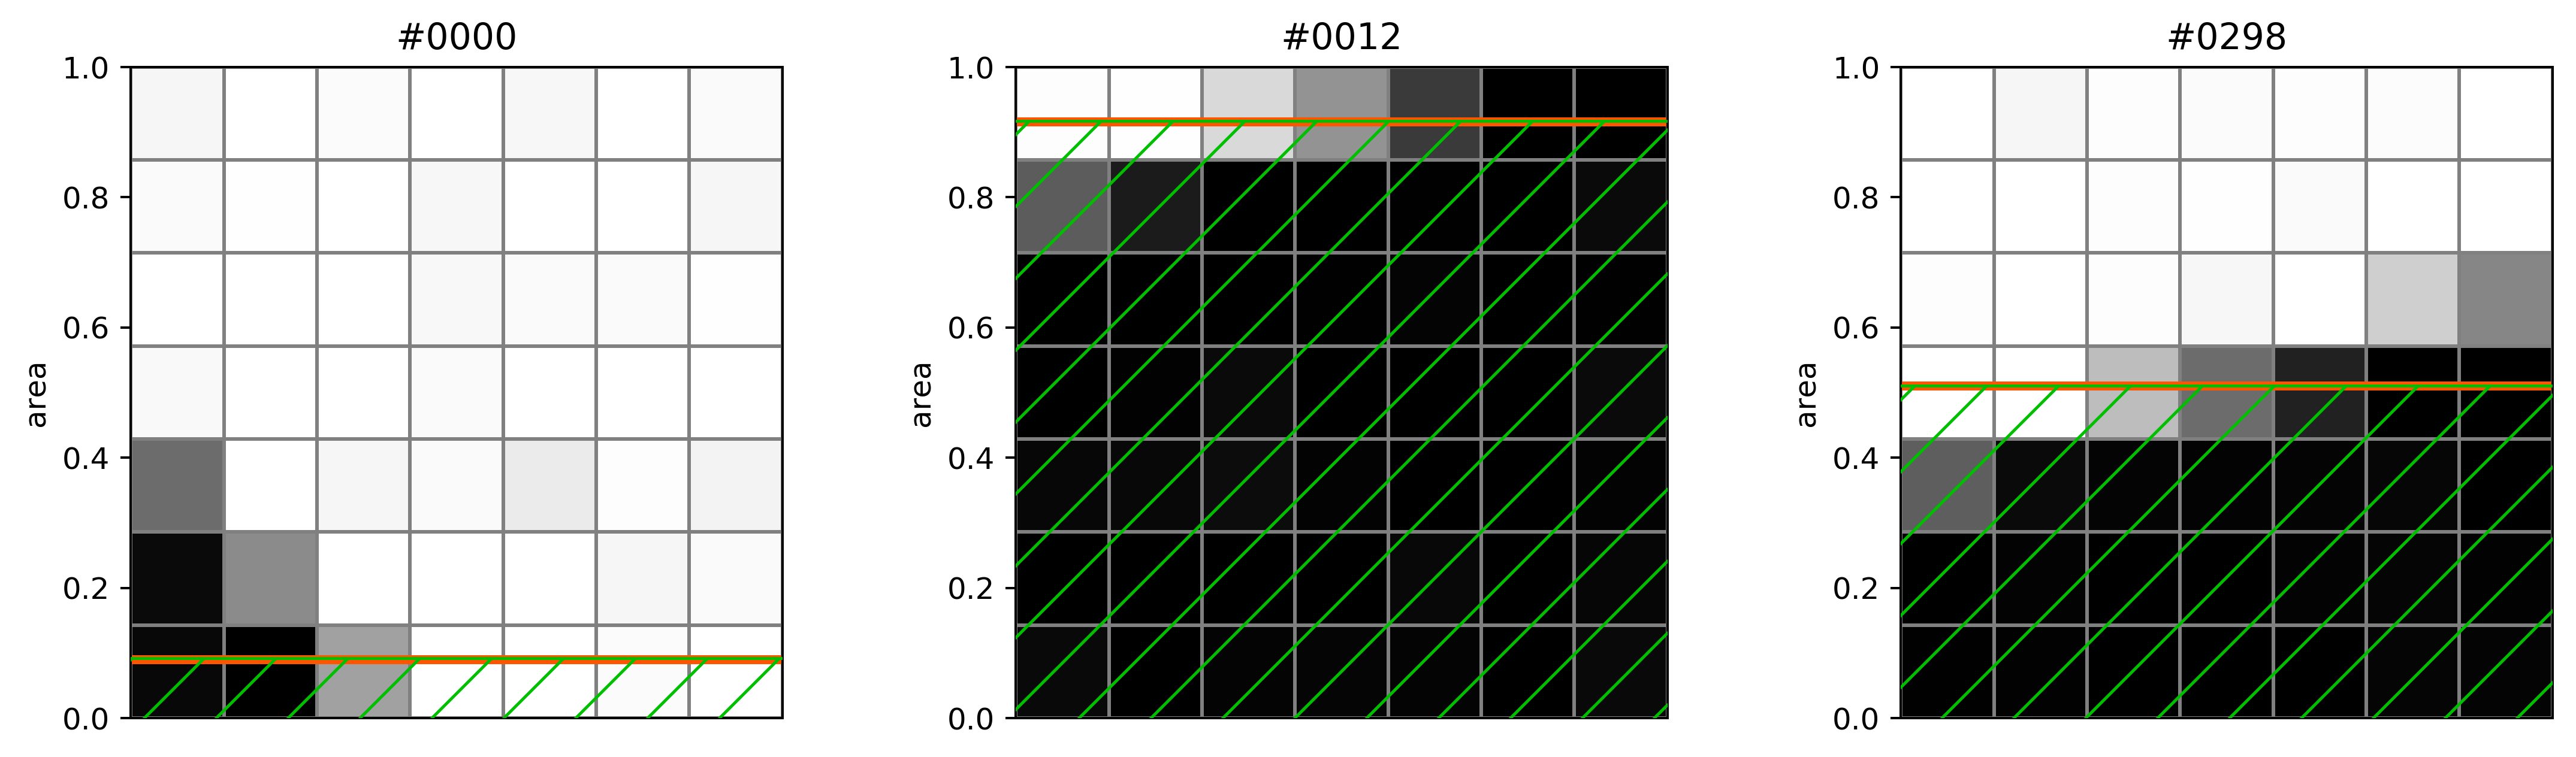

In [21]:
y = model.predict(X)[:, 0]
edge.fancy(data, flavour="area", index=[0, 12, 298], y=y, linewidth=3)

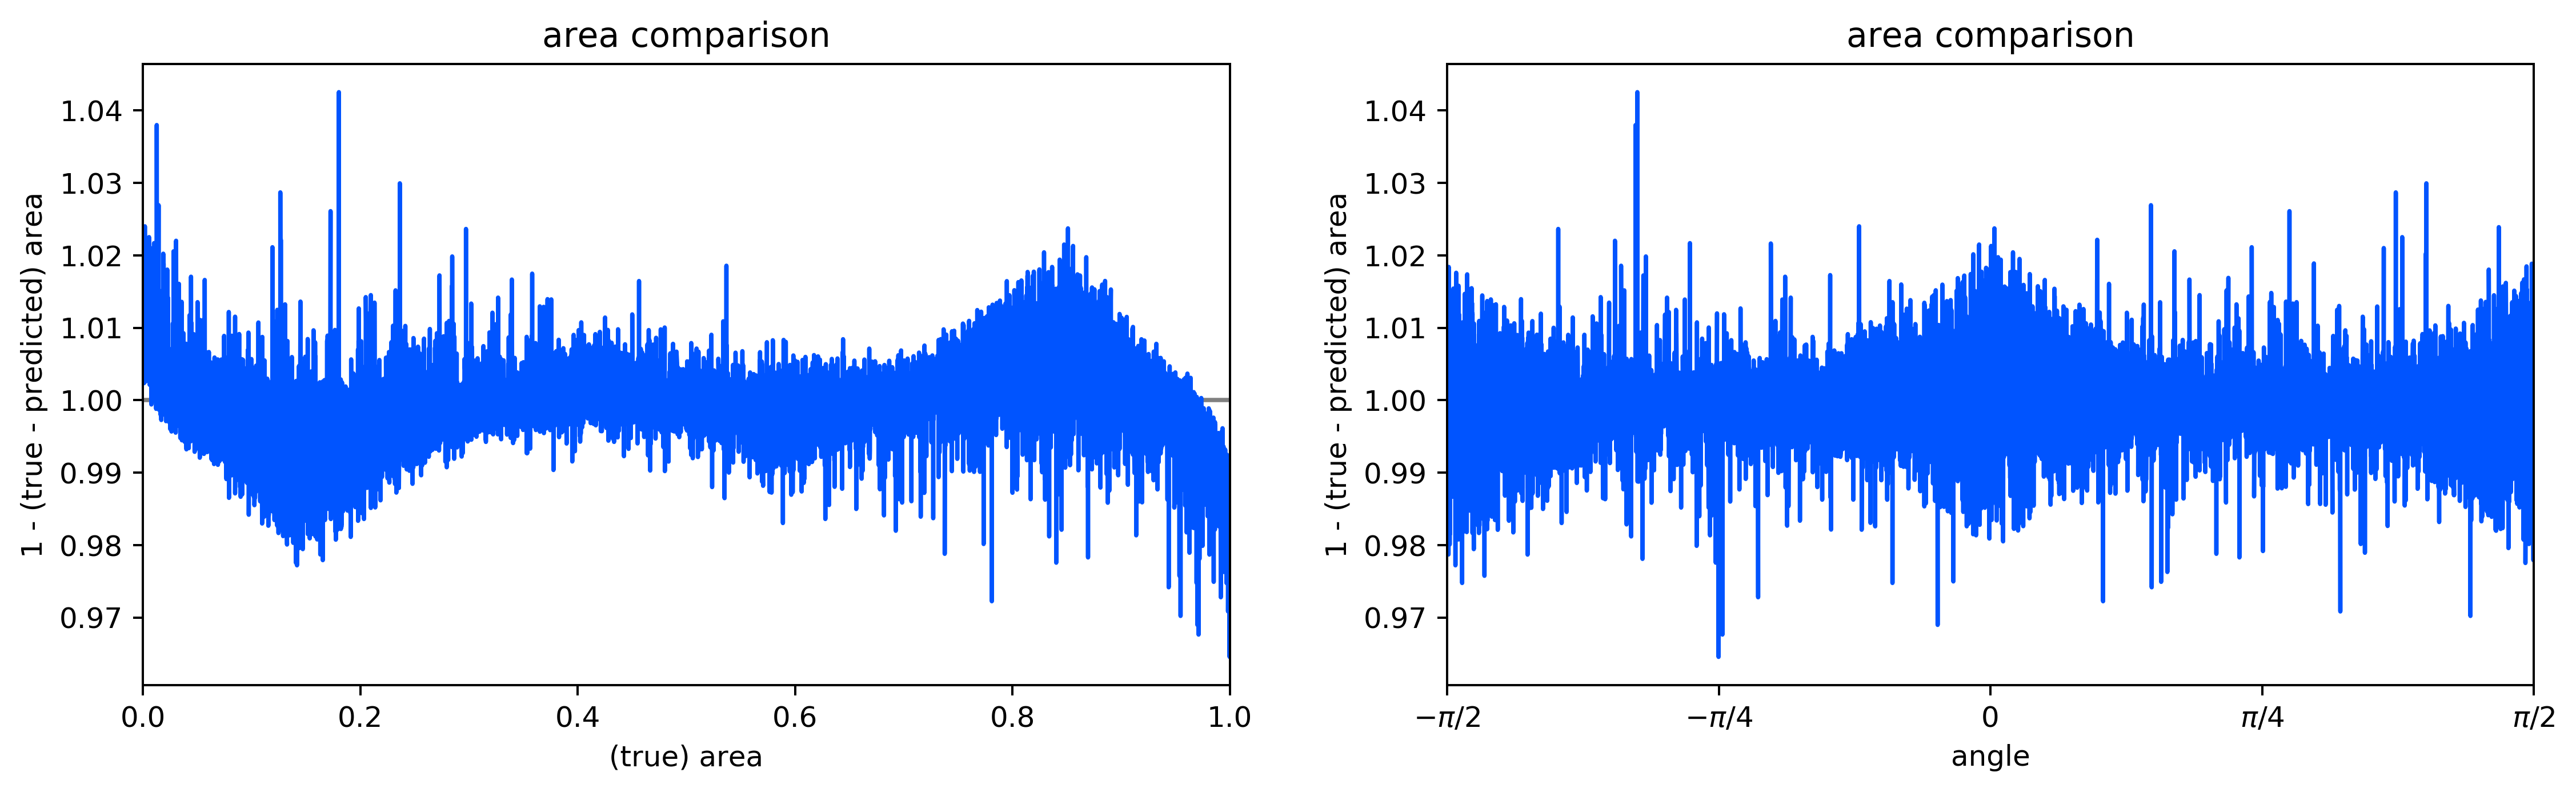

In [22]:
edge.gaze(["compare", "depend"], compare=(Y, y, "area"), angles=data.loc[:, "y_angle"])

In [23]:
np.round(model.layers[0].get_weights()[0].reshape(kernel_shape), 3)

array([[0.128, 0.132, 0.128],
       [0.132, 0.137, 0.132],
       [0.127, 0.131, 0.127]], dtype=float32)

In [24]:
np.round(model.layers[2].get_weights()[0].flatten(), 3)

array([0.019, 0.025, 0.021, 0.019, 0.021, 0.025, 0.02 , 0.025, 0.031,
       0.025, 0.019, 0.026, 0.032, 0.025, 0.02 , 0.023, 0.016, 0.012,
       0.013, 0.024, 0.02 , 0.019, 0.021, 0.013, 0.012, 0.013, 0.021,
       0.018, 0.02 , 0.024, 0.017, 0.014, 0.017, 0.024, 0.02 , 0.024,
       0.03 , 0.023, 0.021, 0.023, 0.03 , 0.024, 0.018, 0.024, 0.02 ,
       0.018, 0.019, 0.024, 0.018], dtype=float32)

# horizontal XOR vertical

$$
    \mathrm{slope} \; a \mapsto \begin{cases} 1 & \mathrm{if} \; -1 < a <  1 \\ 0 & \mathrm{else} \end{cases}
$$

In [25]:
data.loc[:, ["y_slope", "y_horizontal"]].head()

y_slope  y_horizontal
0 -1.12788           0.0
1  0.77902           1.0
2 -0.43403           1.0
3 -0.68854           1.0
4 -0.59926           1.0

# weak or strong decrease or increase

$$
    \mathrm{slope} \; a \mapsto \begin{cases} (1,0,0,0) & \mathrm{if}\phantom{\;\,-1\;<}a \leq -1 \\
                                              (0,1,0,0) & \phantom{\mathrm{if}}    -1 < a \leq \phantom{-}0 \\
                                              (0,0,1,0) & \phantom{\mathrm{if}\;\,-}0 < a \leq +1 \\
                                              (0,0,0,1) & \phantom{\mathrm{if}}    +1 < a \end{cases}
$$

In [26]:
data.loc[:, ["y_slope", "y_1-hot-slope_lt-1", "y_1-hot-slope_lt_0", "y_1-hot-slope_lt_1", "y_1-hot-slope_gt_1"]].head()

y_slope  y_1-hot-slope_lt-1  y_1-hot-slope_lt_0  y_1-hot-slope_lt_1  \
0 -1.12788                 1.0                 0.0                 0.0   
1  0.77902                 0.0                 0.0                 1.0   
2 -0.43403                 0.0                 1.0                 0.0   
3 -0.68854                 0.0                 1.0                 0.0   
4 -0.59926                 0.0                 1.0                 0.0   

   y_1-hot-slope_gt_1  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 0.0

# angle (and slope)

# edge recognition

In [27]:
data.loc[:, "y_Ax" : "y_By"].head()

y_Ax     y_Ay     y_Bx     y_By
0 -0.00000  0.45067  0.39957  0.00000
1  0.20417  0.00000  1.00000  0.61997
2 -0.00000  0.33810  0.77898  0.00000
3  0.33888  1.00000  1.00000  0.54479
4 -0.00000  0.93479  1.00000  0.33553

# length

# noise

# root and intercept

In [28]:
data.loc[:, ["y_root", "y_intercept"]].head()

y_root  y_intercept
0  0.39957      0.45067
1  0.20417     -0.15905
2  0.77898      0.33810
3  1.79122      1.23333
4  1.55990      0.93479

# autoencoder

# shuffling

<Figure size 432x288 with 0 Axes>

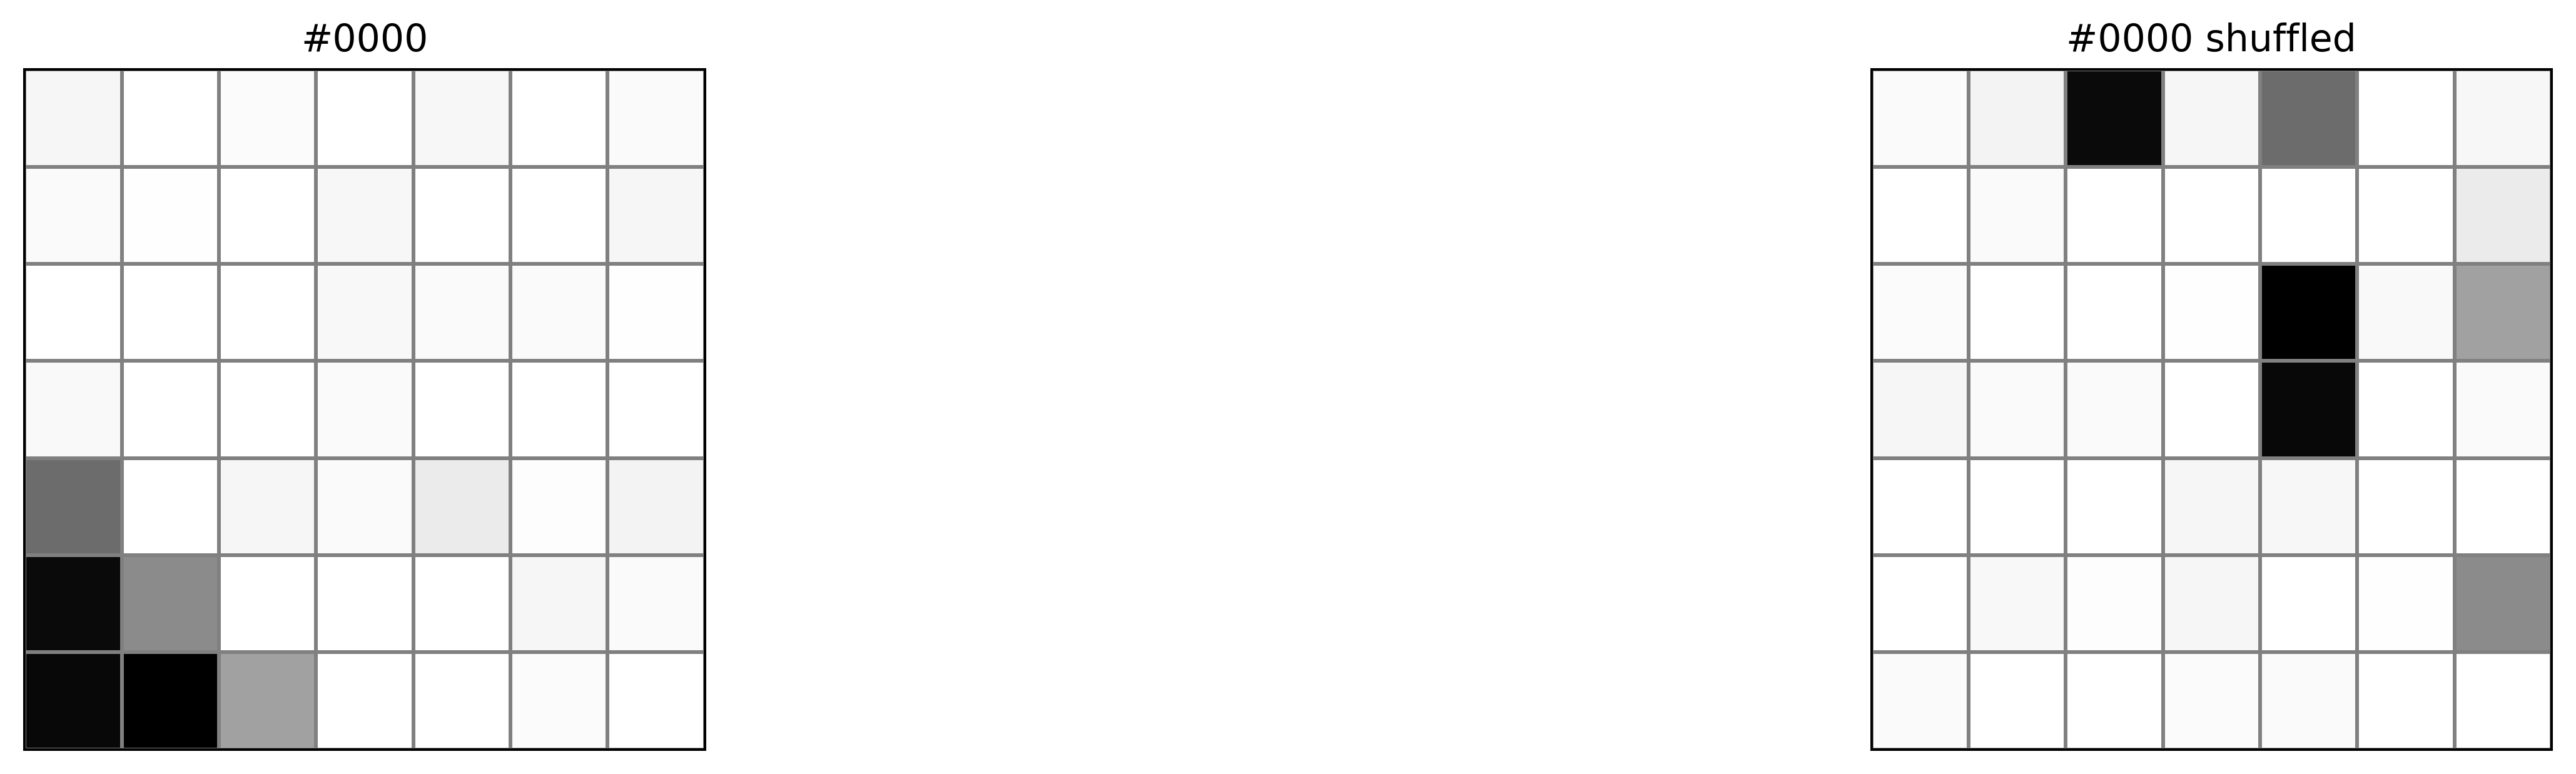

In [29]:
edge.fancy(data, flavour=["line", "shuffle"], index=0, linewidth=0)

# row XOR column prediction